In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# About the churn prediction project

calculate likelihood of person going to leave (churn) and offer discounts

## Binary classification

`g(xi) ~= yi`

`yi in {0, 1}`  -> where 1 is a positive example, e.g. churn, spam, etc. and 0 is negative, e.g. no churn, no spam

In [2]:
remote_csv = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv'

!wget $remote_csv -O data-week-3.csv

--2023-09-28 20:46:42--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 977501 (955K) [text/plain]
Saving to: ‘data-week-3.csv’

data-week-3.csv     100%[===================>] 954.59K  --.-KB/s    in 0.07s   

2023-09-28 20:46:42 (12.6 MB/s) - ‘data-week-3.csv’ saved [977501/977501]



In [3]:
df = pd.read_csv('data-week-3.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [93]:
# clean the column/index names/values
df.columns = df.columns.str.lower().str.replace(' ', '_')

all_categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in all_categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.head().T

,0,1,2,3,4
customerid,7590-vhveg,5575-gnvde,3668-qpybk,7795-cfocw,9237-hqitu
gender,female,male,male,male,female
seniorcitizen,0,0,0,0,0
partner,yes,no,no,no,no
dependents,no,no,no,no,no
tenure,1,34,2,45,2
phoneservice,no,yes,yes,no,yes
multiplelines,no_phone_service,no,no,no_phone_service,no
internetservice,dsl,dsl,dsl,dsl,fiber_optic
onlinesecurity,no,yes,yes,yes,no


In [5]:
tc = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = tc
df.totalcharges = df.totalcharges.fillna(0)
df.totalcharges

0         29.85
1       1889.50
2        108.15
3       1840.75
4        151.65
         ...   
7038    1990.50
7039    7362.90
7040     346.45
7041     306.60
7042    6844.50
Name: totalcharges, Length: 7043, dtype: float64

In [6]:
df.churn

0        no
1        no
2       yes
3        no
4       yes
       ... 
7038     no
7039     no
7040     no
7041    yes
7042     no
Name: churn, Length: 7043, dtype: object

In [7]:
df.churn = (df.churn == 'yes').astype(int)
df.churn

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: churn, Length: 7043, dtype: int64

# Setting up the validation framework

train/validation/test split using scikit-learn

In [54]:
from sklearn.model_selection import train_test_split

In [11]:
# use train_test_split? to view help

df_full_train, df_test = train_test_split(df, test_size=0.2,random_state=1)

In [13]:
# test_size for the validation set -> it's 25% of the df_full_train set,
# i.e. df_full_train is 80% of the entire dataset, we put 20% into test,
# and we want 20% into validation. Therefore the proportion of the validation
# set to the full_train set is 20% / 80% = 0.25
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [14]:
len(df_train), len(df_val), len(df_test)

(4225, 1409, 1409)

In [16]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [17]:
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

In [18]:
del df_train['churn']
del df_val['churn']
del df_test['churn']

# Exploratory data analysis

In [20]:
df_full_train = df_full_train.reset_index(drop=True)
df_full_train

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,5442-pptjy,male,0,yes,yes,12,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.70,258.35,0
1,6261-rcvns,female,0,no,no,42,yes,no,dsl,yes,...,yes,yes,no,yes,one_year,no,credit_card_(automatic),73.90,3160.55,1
2,2176-osjuv,male,0,yes,no,71,yes,yes,dsl,yes,...,no,yes,no,no,two_year,no,bank_transfer_(automatic),65.15,4681.75,0
3,6161-erdgd,male,0,yes,yes,71,yes,yes,dsl,yes,...,yes,yes,yes,yes,one_year,no,electronic_check,85.45,6300.85,0
4,2364-ufrom,male,0,no,no,30,yes,no,dsl,yes,...,no,yes,yes,no,one_year,no,electronic_check,70.40,2044.75,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5629,0781-lkxbr,male,1,no,no,9,yes,yes,fiber_optic,no,...,yes,no,yes,yes,month-to-month,yes,electronic_check,100.50,918.60,1
5630,3507-gasnp,male,0,no,yes,60,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.95,1189.90,0
5631,8868-wozgu,male,0,no,no,28,yes,yes,fiber_optic,no,...,yes,no,yes,yes,month-to-month,yes,electronic_check,105.70,2979.50,1
5632,1251-krreg,male,0,no,no,2,yes,yes,dsl,no,...,no,no,no,no,month-to-month,yes,mailed_check,54.40,114.10,1


In [21]:
df_full_train.isnull().sum()

customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

In [23]:
# get the distribution of churn
# the result is churn rate
df_full_train.churn.value_counts(normalize=True)

churn
0    0.730032
1    0.269968
Name: proportion, dtype: float64

In [35]:
global_churn_rate = df_full_train.churn.mean()
print(f"{global_churn_rate=}")
round(global_churn_rate, 2)

global_churn_rate=0.26996805111821087


0.27

In [26]:
numerical_values = ['tenure', 'monthlycharges', 'totalcharges']

In [27]:
df_full_train.columns

Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'tenure', 'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges', 'churn'],
      dtype='object')

In [28]:
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
       'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod']

In [29]:
df_full_train[categorical].nunique()

gender              2
seniorcitizen       2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
dtype: int64

# Feature importance: churn rate and risk ratio

Find the correlation between some target and categorical column

In [39]:
print(f"{global_churn_rate=}")
churn_male = df_full_train[df_full_train.gender == 'male'].churn.mean()
print(f"{churn_male=}")
churn_female = df_full_train[df_full_train.gender == 'female'].churn.mean()
print(f"{churn_female=}")
churn_has_partner = df_full_train[df_full_train.partner == 'yes'].churn.mean()
print(f"{churn_has_partner=}")
churn_no_partner = df_full_train[df_full_train.partner == 'no'].churn.mean()
print(f"{churn_no_partner=}")

global_churn_rate=0.26996805111821087
churn_male=0.2632135306553911
churn_female=0.27682403433476394
churn_has_partner=0.20503330866025166
churn_no_partner=0.3298090040927694


In [40]:
df_full_train.partner.value_counts()

partner
no     2932
yes    2702
Name: count, dtype: int64

In [41]:
# difference between global churn and other correlated churn (group) -> 
#   > 0 : less likely to churn
#   < 0 : more likely to churn


In [44]:
# Risk Ratio
# risk = group / global   ->
#   > 1 more likely to churn
#   < 1 less likely to churn
churn_no_partner / global_churn

1.2216593879412643

In [43]:
churn_has_partner / global_churn

0.7594724924338315

In [45]:
"""
SELECT
    gender,
    AVG(churn),
    AVG(churn) - global_churn AS diff,
    AVG(churn) / global_churn as risk
FROM
    data
GROUP BY
    gender;
"""

df_full_train.groupby('gender').churn.mean()

gender
female    0.276824
male      0.263214
Name: churn, dtype: float64

In [50]:
from IPython.display import display

In [51]:
for c in categorical:
    df_group = df_full_train.groupby(c).churn.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_churn
    df_group['risk'] = df_group['mean'] / global_churn
    display(df_group)

,mean,count,diff,risk
gender,,,,
female,0.276824,2796,0.006856,1.025396
male,0.263214,2838,-0.006755,0.974980


,mean,count,diff,risk
seniorcitizen,,,,
0,0.242270,4722,-0.027698,0.897403
1,0.413377,912,0.143409,1.531208


,mean,count,diff,risk
partner,,,,
no,0.329809,2932,0.059841,1.221659
yes,0.205033,2702,-0.064935,0.759472


,mean,count,diff,risk
dependents,,,,
no,0.313760,3968,0.043792,1.162212
yes,0.165666,1666,-0.104302,0.613651


,mean,count,diff,risk
phoneservice,,,,
no,0.241316,547,-0.028652,0.893870
yes,0.273049,5087,0.003081,1.011412


,mean,count,diff,risk
multiplelines,,,,
no,0.257407,2700,-0.012561,0.953474
no_phone_service,0.241316,547,-0.028652,0.893870
yes,0.290742,2387,0.020773,1.076948


,mean,count,diff,risk
internetservice,,,,
dsl,0.192347,1934,-0.077621,0.712482
fiber_optic,0.425171,2479,0.155203,1.574895
no,0.077805,1221,-0.192163,0.288201


,mean,count,diff,risk
onlinesecurity,,,,
no,0.420921,2801,0.150953,1.559152
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.153226,1612,-0.116742,0.567570


,mean,count,diff,risk
onlinebackup,,,,
no,0.404323,2498,0.134355,1.497672
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.217232,1915,-0.052736,0.804660


,mean,count,diff,risk
deviceprotection,,,,
no,0.395875,2473,0.125907,1.466379
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.230412,1940,-0.039556,0.853480


,mean,count,diff,risk
techsupport,,,,
no,0.418914,2781,0.148946,1.551717
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.159926,1632,-0.110042,0.592390


,mean,count,diff,risk
streamingtv,,,,
no,0.342832,2246,0.072864,1.269897
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.302723,2167,0.032755,1.121328


,mean,count,diff,risk
streamingmovies,,,,
no,0.338906,2213,0.068938,1.255358
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.307273,2200,0.037305,1.138182


,mean,count,diff,risk
contract,,,,
month-to-month,0.431701,3104,0.161733,1.599082
one_year,0.120573,1186,-0.149395,0.446621
two_year,0.028274,1344,-0.241694,0.104730


,mean,count,diff,risk
paperlessbilling,,,,
no,0.172071,2313,-0.097897,0.637375
yes,0.338151,3321,0.068183,1.252560


,mean,count,diff,risk
paymentmethod,,,,
bank_transfer_(automatic),0.168171,1219,-0.101797,0.622928
credit_card_(automatic),0.164339,1217,-0.105630,0.608733
electronic_check,0.455890,1893,0.185922,1.688682
mailed_check,0.193870,1305,-0.076098,0.718121


# Feature importance: mutual information

In [55]:
from sklearn.metrics import mutual_info_score

In [58]:
# order of variables doesn't matter
print(mutual_info_score(df_full_train.churn, df_full_train.contract))
print(mutual_info_score(df_full_train.contract, df_full_train.churn))

0.0983203874041556
0.0983203874041556


In [59]:
print(mutual_info_score(df_full_train.churn, df_full_train.gender))

0.0001174846211139946


In [60]:
print(mutual_info_score(df_full_train.churn, df_full_train.partner))

0.009967689095399745


In [61]:
def mutual_info_churn_score(series):
    return mutual_info_score(series, df_full_train.churn)

In [63]:
# now apply to all of the categories and sort by highest score descending,
# to see which are most important.
# the top results are most important.
mi = df_full_train[categorical].apply(mutual_info_churn_score)
mi.sort_values(ascending=False)

contract            0.098320
onlinesecurity      0.063085
techsupport         0.061032
internetservice     0.055868
onlinebackup        0.046923
deviceprotection    0.043453
paymentmethod       0.043210
streamingtv         0.031853
streamingmovies     0.031581
paperlessbilling    0.017589
dependents          0.012346
partner             0.009968
seniorcitizen       0.009410
multiplelines       0.000857
phoneservice        0.000229
gender              0.000117
dtype: float64

# Feature importance: correlation

In [65]:
# Pearson correlation coefficient - measure dependency between 2 variables/datasets
# say we have 2 variables x and y. -1 <= r <= 1 where r is the correlation coefficient
# negative r means less correlation, positive r means more correlation
df_full_train.tenure.max()

72

In [68]:
# x -> tenure
# y -> churn
# possibilities:
#   positive correlation: longer tenure, more churn
#   negative correlation: longer tenure, less churn
#   zero correlation: no effect
df_full_train[numerical_values].corrwith(df_full_train.churn)

tenure           -0.351885
monthlycharges    0.196805
totalcharges     -0.196353
dtype: float64

In [70]:
# results explanation:
#  the longer a customer stays with us, the less they will churn (due to tenure correlation being negative)
#  the more monthly charges, the more likely for customer to churn
#  the more people pay (total charges), the less like for them to churn

In [71]:
df_full_train[df_full_train.tenure <= 2].churn.mean()

0.5953420669577875

# Feature importance: one-hot encoding

In [73]:
from sklearn.feature_extraction import DictVectorizer

In [76]:
df_train[['gender', 'contract']].iloc[:10].to_dict()

{'gender': {0: 'female',
  1: 'male',
  2: 'female',
  3: 'female',
  4: 'female',
  5: 'male',
  6: 'male',
  7: 'female',
  8: 'female',
  9: 'female'},
 'contract': {0: 'two_year',
  1: 'month-to-month',
  2: 'month-to-month',
  3: 'month-to-month',
  4: 'two_year',
  5: 'month-to-month',
  6: 'month-to-month',
  7: 'month-to-month',
  8: 'two_year',
  9: 'month-to-month'}}

In [94]:
train_dicts = df_train[categorical + numerical_values].to_dict(orient='records')
train_dicts[0]

{'gender': 'female',
 'seniorcitizen': 0,
 'partner': 'yes',
 'dependents': 'yes',
 'phoneservice': 'yes',
 'multiplelines': 'yes',
 'internetservice': 'fiber_optic',
 'onlinesecurity': 'yes',
 'onlinebackup': 'yes',
 'deviceprotection': 'yes',
 'techsupport': 'yes',
 'streamingtv': 'yes',
 'streamingmovies': 'yes',
 'contract': 'two_year',
 'paperlessbilling': 'yes',
 'paymentmethod': 'electronic_check',
 'tenure': 72,
 'monthlycharges': 115.5,
 'totalcharges': 8425.15}

In [102]:
dv = DictVectorizer(sparse=False)
# can also do X_train = dv.fit_transform(train_dicts) as a shortcut to the 2 following
dv.fit(train_dicts)
X_train = dv.transform(train_dicts)

val_dicts = df_val[categorical + numerical_values].to_dict(orient='records')
X_val = dv.transform(val_dicts)

# Logistic regression

In [103]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [104]:
z = np.linspace(-5, 5, 51)
z

array([-5. , -4.8, -4.6, -4.4, -4.2, -4. , -3.8, -3.6, -3.4, -3.2, -3. ,
       -2.8, -2.6, -2.4, -2.2, -2. , -1.8, -1.6, -1.4, -1.2, -1. , -0.8,
       -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,
        1.6,  1.8,  2. ,  2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,
        3.8,  4. ,  4.2,  4.4,  4.6,  4.8,  5. ])

In [105]:
sigmoid(z)

array([0.00669285, 0.00816257, 0.0099518 , 0.01212843, 0.01477403,
       0.01798621, 0.02188127, 0.02659699, 0.03229546, 0.03916572,
       0.04742587, 0.05732418, 0.06913842, 0.0831727 , 0.09975049,
       0.11920292, 0.14185106, 0.16798161, 0.19781611, 0.23147522,
       0.26894142, 0.31002552, 0.35434369, 0.40131234, 0.450166  ,
       0.5       , 0.549834  , 0.59868766, 0.64565631, 0.68997448,
       0.73105858, 0.76852478, 0.80218389, 0.83201839, 0.85814894,
       0.88079708, 0.90024951, 0.9168273 , 0.93086158, 0.94267582,
       0.95257413, 0.96083428, 0.96770454, 0.97340301, 0.97811873,
       0.98201379, 0.98522597, 0.98787157, 0.9900482 , 0.99183743,
       0.99330715])

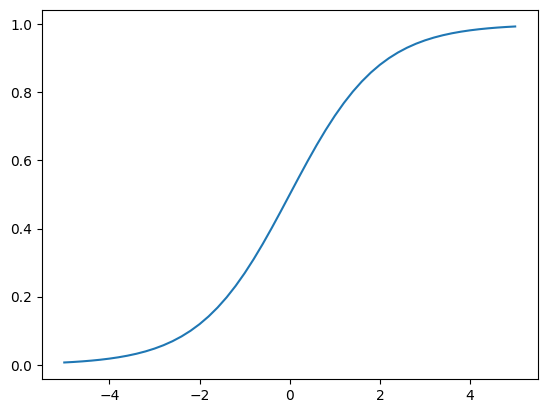

In [107]:
plt.plot(z, sigmoid(z))

In [108]:
def linear_regression(xi):
    result = w0
    for j in range(len(w)):
        result = result + xi[j] * w[j]
    return result

In [109]:
def logistic_regression(xi):
    score = w0
    for j in range(len(w)):
        score = score + xi[j] * w[j]

    result = sigmoid(score)
    return result

In [112]:
# both linear/logistic regression are called "linear models" because they both use
# dot product (the W^T * xi part)
# they're both similar, but logistic regression converts the result to a probability

# Training logistic regression with scikit-learn

In [114]:
from sklearn.linear_model import LogisticRegression

In [115]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [117]:
model.intercept_[0]

-0.10904479046070133

In [116]:
model.coef_[0].round(3)

array([ 0.475, -0.175, -0.408, -0.03 , -0.078,  0.063, -0.089, -0.081,
       -0.034, -0.073, -0.335,  0.317, -0.089,  0.004, -0.258,  0.141,
        0.009,  0.063, -0.089, -0.081,  0.266, -0.089, -0.284, -0.231,
        0.124, -0.166,  0.058, -0.087, -0.032,  0.071, -0.059,  0.141,
       -0.249,  0.215, -0.12 , -0.089,  0.102, -0.071, -0.089,  0.052,
        0.213, -0.089, -0.232, -0.07 ,  0.   ])

In [119]:
model.predict(X_train)  # hard predictions - these are all churn

array([0, 1, 1, ..., 1, 0, 1])

In [122]:
# predict probability (soft predictions)
# 2nd element of each pair is probability of churn
y_pred = model.predict_proba(X_val)[:, 1]

In [123]:
y_pred

array([0.00899456, 0.20447551, 0.21218361, ..., 0.13636236, 0.79975428,
       0.83739606])

In [126]:
churn_decision = (y_pred >= 0.5)
churn_decision

array([False, False, False, ..., False,  True,  True])

In [128]:
# the customers that we will send the promotional email with discount, i.e.
# the customers who are more likely to churn
df_val[churn_decision].customerid

3       8433-wxgna
8       3440-jpscl
11      2637-fkfsy
12      7228-omtpn
19      6711-fldfb
           ...    
1397    5976-jcjrh
1398    2034-cgrhz
1399    5276-kqwhg
1407    6521-yytyi
1408    3049-solay
Name: customerid, Length: 311, dtype: object

In [129]:
# accuracy
print(y_val)
churn_decision.astype(int)

[0 0 0 ... 0 1 1]


array([0, 0, 0, ..., 0, 1, 1])

In [131]:
(y_val == churn_decision).mean()

0.8034066713981547

In [133]:
df_pred = pd.DataFrame()
df_pred['probability'] = y_pred
df_pred['prediction'] = churn_decision.astype(int)
df_pred['actual'] = y_val

In [134]:
df_pred

,probability,prediction,actual
0,0.008995,0,0
1,0.204476,0,0
2,0.212184,0,0
3,0.543029,1,1
4,0.213752,0,0
...,...,...,...
1404,0.313636,0,0
1405,0.039351,0,1
1406,0.136362,0,0
1407,0.799754,1,1


In [135]:
df_pred['correct'] = df_pred.prediction == df_pred.actual
df_pred

,probability,prediction,actual,correct
0,0.008995,0,0,True
1,0.204476,0,0,True
2,0.212184,0,0,True
3,0.543029,1,1,True
4,0.213752,0,0,True
...,...,...,...,...
1404,0.313636,0,0,True
1405,0.039351,0,1,False
1406,0.136362,0,0,True
1407,0.799754,1,1,True


In [137]:
# model is 80% correct
df_pred.correct.mean()

0.8034066713981547

# Model interpretation

In [139]:
dv.get_feature_names_out()

array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year', 'dependents=no', 'dependents=yes',
       'deviceprotection=no', 'deviceprotection=no_internet_service',
       'deviceprotection=yes', 'gender=female', 'gender=male',
       'internetservice=dsl', 'internetservice=fiber_optic',
       'internetservice=no', 'monthlycharges', 'multiplelines=no',
       'multiplelines=no_phone_service', 'multiplelines=yes',
       'onlinebackup=no', 'onlinebackup=no_internet_service',
       'onlinebackup=yes', 'onlinesecurity=no',
       'onlinesecurity=no_internet_service', 'onlinesecurity=yes',
       'paperlessbilling=no', 'paperlessbilling=yes', 'partner=no',
       'partner=yes', 'paymentmethod=bank_transfer_(automatic)',
       'paymentmethod=credit_card_(automatic)',
       'paymentmethod=electronic_check', 'paymentmethod=mailed_check',
       'phoneservice=no', 'phoneservice=yes', 'seniorcitizen',
       'streamingmovies=no', 'streamingmovies=no_internet_service',

In [140]:
model.coef_[0].round(3)

array([ 0.475, -0.175, -0.408, -0.03 , -0.078,  0.063, -0.089, -0.081,
       -0.034, -0.073, -0.335,  0.317, -0.089,  0.004, -0.258,  0.141,
        0.009,  0.063, -0.089, -0.081,  0.266, -0.089, -0.284, -0.231,
        0.124, -0.166,  0.058, -0.087, -0.032,  0.071, -0.059,  0.141,
       -0.249,  0.215, -0.12 , -0.089,  0.102, -0.071, -0.089,  0.052,
        0.213, -0.089, -0.232, -0.07 ,  0.   ])

In [142]:
dict(zip(dv.get_feature_names_out(), model.coef_[0].round(3)))

{'contract=month-to-month': 0.475,
 'contract=one_year': -0.175,
 'contract=two_year': -0.408,
 'dependents=no': -0.03,
 'dependents=yes': -0.078,
 'deviceprotection=no': 0.063,
 'deviceprotection=no_internet_service': -0.089,
 'deviceprotection=yes': -0.081,
 'gender=female': -0.034,
 'gender=male': -0.073,
 'internetservice=dsl': -0.335,
 'internetservice=fiber_optic': 0.317,
 'internetservice=no': -0.089,
 'monthlycharges': 0.004,
 'multiplelines=no': -0.258,
 'multiplelines=no_phone_service': 0.141,
 'multiplelines=yes': 0.009,
 'onlinebackup=no': 0.063,
 'onlinebackup=no_internet_service': -0.089,
 'onlinebackup=yes': -0.081,
 'onlinesecurity=no': 0.266,
 'onlinesecurity=no_internet_service': -0.089,
 'onlinesecurity=yes': -0.284,
 'paperlessbilling=no': -0.231,
 'paperlessbilling=yes': 0.124,
 'partner=no': -0.166,
 'partner=yes': 0.058,
 'paymentmethod=bank_transfer_(automatic)': -0.087,
 'paymentmethod=credit_card_(automatic)': -0.032,
 'paymentmethod=electronic_check': 0.071,


In [143]:
small = ['contract', 'tenure', 'monthlycharges']

In [146]:
df_train[small].iloc[:10].to_dict(orient='records')

[{'contract': 'two_year', 'tenure': 72, 'monthlycharges': 115.5},
 {'contract': 'month-to-month', 'tenure': 10, 'monthlycharges': 95.25},
 {'contract': 'month-to-month', 'tenure': 5, 'monthlycharges': 75.55},
 {'contract': 'month-to-month', 'tenure': 5, 'monthlycharges': 80.85},
 {'contract': 'two_year', 'tenure': 18, 'monthlycharges': 20.1},
 {'contract': 'month-to-month', 'tenure': 4, 'monthlycharges': 30.5},
 {'contract': 'month-to-month', 'tenure': 1, 'monthlycharges': 75.1},
 {'contract': 'month-to-month', 'tenure': 1, 'monthlycharges': 70.3},
 {'contract': 'two_year', 'tenure': 72, 'monthlycharges': 19.75},
 {'contract': 'month-to-month', 'tenure': 6, 'monthlycharges': 109.9}]

In [149]:
dicts_train_small = df_train[small].to_dict(orient='records')
dicts_val_small = df_val[small].to_dict(orient='records')

In [151]:
dv_small = DictVectorizer(sparse=False)
dv_small.fit(dicts_train_small)

DictVectorizer(sparse=False)

In [153]:
X_train_small = dv_small.transform(dicts_train_small)

In [154]:
model_small = LogisticRegression()
model_small.fit(X_train_small, y_train)

LogisticRegression()

In [157]:
w0 = model_small.intercept_[0]
w0

-2.476775664719812

In [160]:
w = model_small.coef_[0]
w.round(3)

array([ 0.97 , -0.025, -0.949,  0.027, -0.036])

In [162]:
dict(zip(dv_small.get_feature_names_out(), w.round(3)))

{'contract=month-to-month': 0.97,
 'contract=one_year': -0.025,
 'contract=two_year': -0.949,
 'monthlycharges': 0.027,
 'tenure': -0.036}

In [163]:
-2.47 + (-0.949) + 30 * 0.027 + 24 * (-0.036)

-3.473

In [164]:
sigmoid(_)

0.030090303318277657